## House Prices: Advanced Regression Techniques
**Problem statement**

This is the Kaggle competition [House Prices: Advanced Regression Techniques](http://https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview).

**Extract**
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

The aim of this project is to predict house sale prices using machine learning.


**Note**: [This](https://www.kaggle.com/patilneha09/house-prices-eda-and-prediction) is the link to my Kaggle code for the above problem statement.

In [1]:
# Import necesaary packages
import numpy as np 
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.ensemble import RandomForestClassifier
# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")
import xgboost
from sklearn.metrics import explained_variance_score
from xgboost import XGBRegressor

['test.csv', 'train.csv', 'sample_submission.csv', 'data_description.txt']


In [2]:
# Load datasets
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Wrangling
Data wrangling is the step where we deal with missing or incorrect data. 
Lets analyze our dataset and find areas we need to work on.
In train and test dataset I found the following problem areas:
1. Missing data in categoraical variables - Variables like MasVnrType,BsmtQual etc have NaN if that particular feature is not present in that house. We can fill these missing values with None.
2. Missing data in numerical variables - The Basement and Garage variables have missing values. Upon furthur analysis I found that the missing values correspond to the house that do not have a basement or a garage. We can fill NaN values with 0 for these variables.
3. In train dataset 'Electrical' column has one value missing- We can fill the missing value with the most common value of this column.
4. In test dataset the 'Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional','SaleType','MSZoning' columns have one or two values missing. Instead of dropping these variables we can fill the missing values with the most common occurance.
6. Few columns like 'PoolQC','Fence','MiscFeature','GarageYrBlt','Alley' have a large number of missing values. We can drop these columns.

In [3]:
# To operate on both dataframes simulatenously
combine=[train,test]

In [4]:
# Check if any data is duplicated
sum(train['Id'].duplicated()),sum(test['Id'].duplicated())

(0, 0)

In [5]:
# Drop Id column from train dataset
train.drop(columns=['Id'],inplace=True)

In [6]:
miss_cols=['MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
           'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond']
zero_list=['LotFrontage','MasVnrArea','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2',
           'BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']
drop_cols=['PoolQC','Fence','MiscFeature','GarageYrBlt','Alley']
for df in combine:
    # Fill missing values in cetgorical variables with None
    for col in miss_cols:
        df[col]=df[col].fillna('None')
    # Fill missing values in numerical variables with 0
    for col in zero_list:
        df[col]=df[col].fillna(0)
    # Drop columns with large number of missing values
    df.drop(columns=drop_cols,inplace=True)


In [7]:
# Fill missing value in Electrical in train dataset
index=train[train['Electrical'].isnull()].index
train.loc[index,'Electrical']=train['Electrical'].mode()[0]

In [8]:
# Fill missing values in categorical variables in test dataset
mode_list=['Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional','SaleType','MSZoning']
for col in mode_list:
    mode=test[col].mode()
    test[col]=test[col].fillna(mode[0])

In [9]:
# Check if the above operations worked correctly
train.isnull().sum().max(),test.isnull().sum().max()

(0, 0)

## Visualisations

> Our main focus to find features that influence price of a house.
Lets plot the correlation matrix to see which features have a strong correlation with SalePrice.

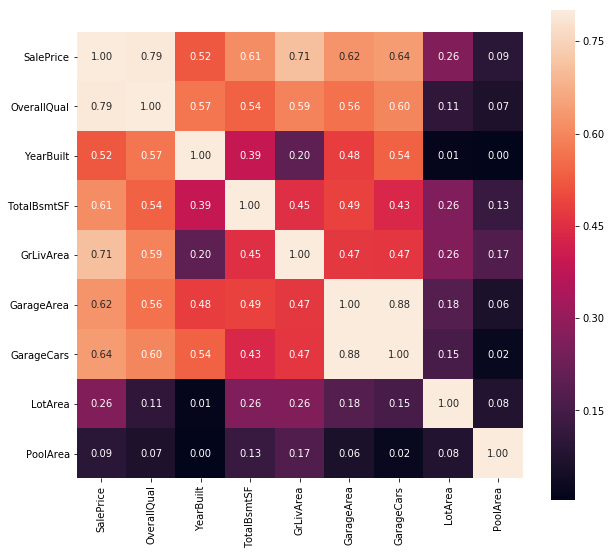

In [10]:
# Plot the correlation matrix
imp_list=['SalePrice','OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea' ,'GarageArea',
         'GarageCars','LotArea','PoolArea']
corrmat = train[imp_list].corr()
f, ax = plt.subplots(figsize=(10, 9))
sb.heatmap(corrmat, vmax=.8, square=True,cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10});

>**Observation** Features that have strong and positive correlation with SalePrice are Overall Ouality, Year Built, Basement Area, Above groud area and Garage Area.
SalePrice has a strong positive correlation with these features meaning that if any of the features increase in value then SalePrice will also increase.

### Univariate Analysis

In [11]:
# Set the base color as blue
base_color=sb.color_palette()[0]

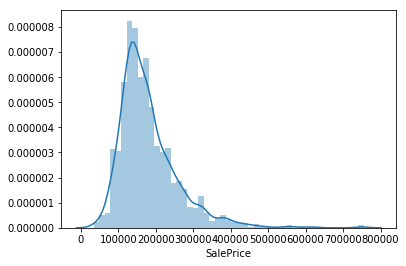

In [12]:
# Univariate plot SalePrice
sb.distplot(train['SalePrice']);

The plot of SalePrice is skewed in nature. Lets apply log transform to a normal distribution curve.

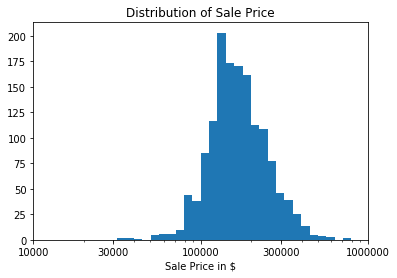

In [13]:
# Univariate plot of SalePrice using log transform
bins=10**np.arange(0,np.log(train['SalePrice'].max())+0.05,0.05)
plt.hist(data=train,x='SalePrice',bins=bins);
plt.xscale('log');
plt.xlim(10000,1000000);
xticks=[10000,30000,100000,300000,1000000]
plt.xticks(xticks,xticks);
plt.xlabel('Sale Price in $');
plt.title('Distribution of Sale Price');

>**Observation** The distribution of SalePrice is unimodal in nature with a peak at 1500000 dollars.  

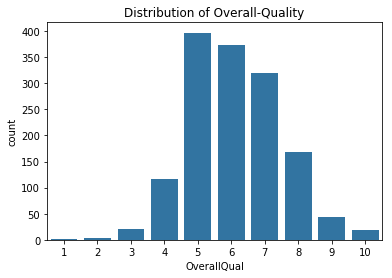

In [14]:
# Univariate plot of Overall Quality
sb.countplot(data=train,x='OverallQual',color=base_color);
plt.title('Distribution of Overall-Quality');

>**Observation** Majority of the houses in the dataset have average quality rating with minimum at the extreme ends.

### Bivariate Analysis

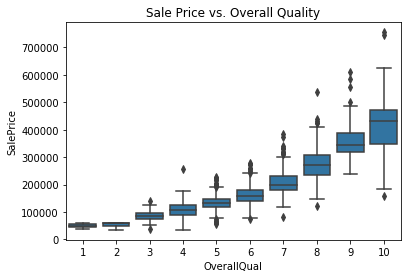

In [15]:
# Bivariate plot of SalePrice and OverallQual
sb.boxplot(data=train,x='OverallQual',y='SalePrice',color=base_color);
plt.title('Sale Price vs. Overall Quality');

>**Observation**
From the above plot of SalePrice vs. OverallQual it is clear that the Quality has a strong positive correlation with Sale Price. As quality increases the price of the house also increases. 

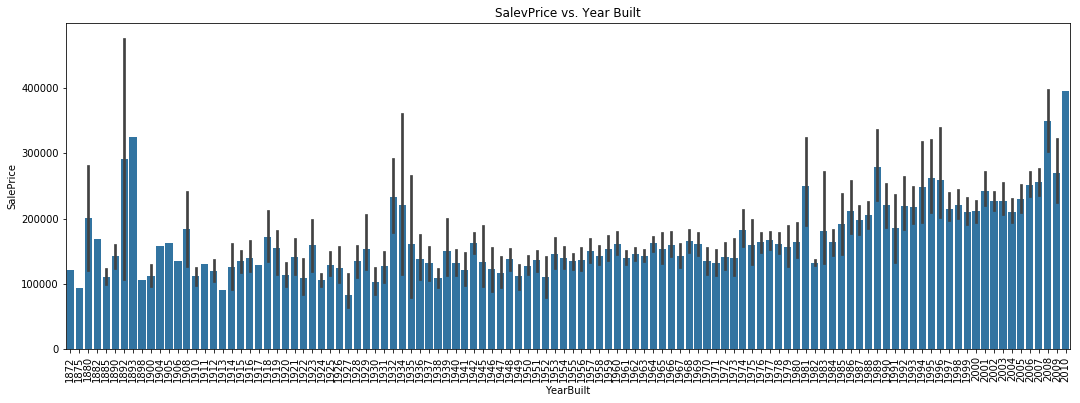

In [16]:
# Bivariate plot SalePrice and YearBuilt
plt.figure(figsize=(18,6))
sb.barplot(data=train,x='YearBuilt',y='SalePrice',color=base_color);
plt.xticks(rotation=90);
plt.title('SalevPrice vs. Year Built');

>**Observation**
We can see a steady increase in the SalePrice as the value of YearBuilt increases. There are sudden peaks in between. This can be due to inflation or some other reason. We can get a clear picture when we plot it with other variables. The large error bars indicate that there are less number of sale listed for that year.

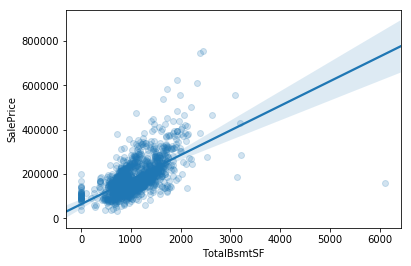

In [17]:
# Bivariate plot of Sale Price and Basement Area 
sb.regplot(data=train,x='TotalBsmtSF',y='SalePrice',scatter_kws={'alpha':1/5});

>**Observation**
There is an oultlier present in the BasementArea feature. Lets remove it and look at the plot again.

In [18]:
# Removing outliers from Basement Area
index=train[train['TotalBsmtSF']>4000].index
train.drop(index,inplace=True)

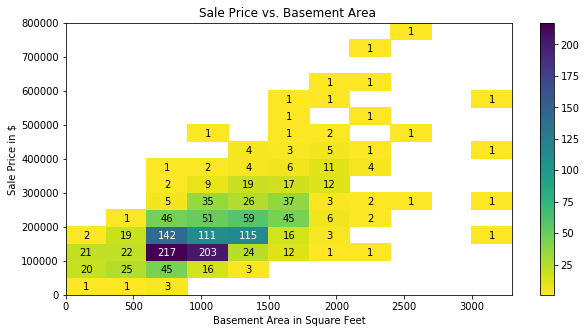

In [19]:
# Bivariate plot of Sale Price and Basement Area 
plt.figure(figsize=(10,5))
bins_x = np.arange(0, train['TotalBsmtSF'].max()+300, 300)
bins_y = np.arange(0, train['SalePrice'].max()+50000, 50000)
h2d=plt.hist2d(data=train,x='TotalBsmtSF',y='SalePrice',cmin=0.5,cmap='viridis_r',bins=[bins_x,bins_y]);
plt.colorbar();
plt.xlabel('Basement Area in Square Feet');
plt.ylabel('Sale Price in $');
plt.title('Sale Price vs. Basement Area ');
counts = h2d[0]
# loop through the cell counts and add text annotations for each
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 100: # increase visibility on darkest cells
            plt.text(bins_x[i]+150, bins_y[j]+25000, int(c),
                     ha = 'center', va = 'center', color = 'white')
        elif c > 0:
            plt.text(bins_x[i]+150, bins_y[j]+25000, int(c),
                     ha = 'center', va = 'center', color = 'black')

>**Observation**
There is a positive correlation between SalePrice and BasementArea. Most of the houses have a basement between 500-1500 square feet.

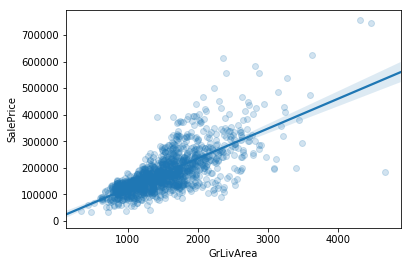

In [20]:
# Bivariate plot of Sale Price and Above Ground Area
sb.regplot(data=train,x='GrLivArea',y='SalePrice',scatter_kws={'alpha':1/5});

>**Observation**
Lets remove the outliers and plot the graph again.

In [21]:
# Remove outliers from Above Ground Area
index=train[train['GrLivArea']>4000].index
train.drop(index,inplace=True)

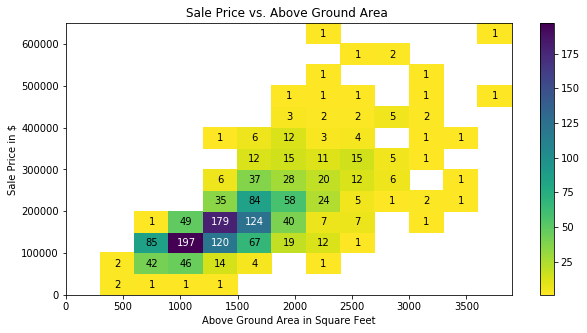

In [22]:
# Bivariate plot of Sale Price and Above Ground Area
plt.figure(figsize=(10,5))
bins_x = np.arange(0, train['GrLivArea'].max()+300, 300)
bins_y = np.arange(0, train['SalePrice'].max()+50000, 50000)
h2d=plt.hist2d(data=train,x='GrLivArea',y='SalePrice',cmin=0.5,cmap='viridis_r',bins=[bins_x,bins_y]);
plt.colorbar();
plt.xlabel('Above Ground Area in Square Feet');
plt.ylabel('Sale Price in $');
plt.title('Sale Price vs. Above Ground Area ');
counts = h2d[0]
# loop through the cell counts and add text annotations for each
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 100: # increase visibility on darkest cells
            plt.text(bins_x[i]+150, bins_y[j]+25000, int(c),
                     ha = 'center', va = 'center', color = 'white')
        elif c > 0:
            plt.text(bins_x[i]+150, bins_y[j]+25000, int(c),
                     ha = 'center', va = 'center', color = 'black')

>**Observation**
SalePrice and AboveGroundArea have a positive correlation. Bulk of the data lies between 1000-2000 square feet.

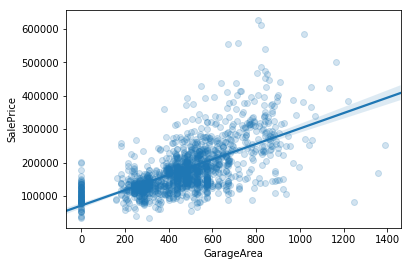

In [23]:
sb.regplot(data=train,x='GarageArea',y='SalePrice',scatter_kws={'alpha':1/5});

>**Observation**
The points after 1200 in Garage Area may look like outliers but the reason for low price can be on of the other factors. Lets leave it as it is.

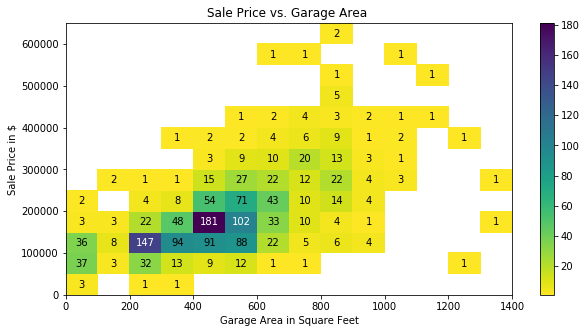

In [24]:
# Bivariate plot of Sale Price and Garage Area
plt.figure(figsize=(10,5))
bins_x = np.arange(0, train['GarageArea'].max()+100, 100)
bins_y = np.arange(0, train['SalePrice'].max()+50000, 50000)
h2d=plt.hist2d(data=train,x='GarageArea',y='SalePrice',cmin=0.5,cmap='viridis_r',bins=[bins_x,bins_y]);
plt.colorbar();
plt.xlabel('Garage Area in Square Feet');
plt.ylabel('Sale Price in $');
plt.title('Sale Price vs. Garage Area ');
counts = h2d[0]
# loop through the cell counts and add text annotations for each
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 100: # increase visibility on darkest cells
            plt.text(bins_x[i]+50, bins_y[j]+25000, int(c),
                     ha = 'center', va = 'center', color = 'white')
        elif c > 0:
            plt.text(bins_x[i]+50, bins_y[j]+25000, int(c),
                     ha = 'center', va = 'center', color = 'black')

>**Observation**
SalePrice and GarageArea have a positive correlation. Bulk of the data lies between 200-600 square feet.



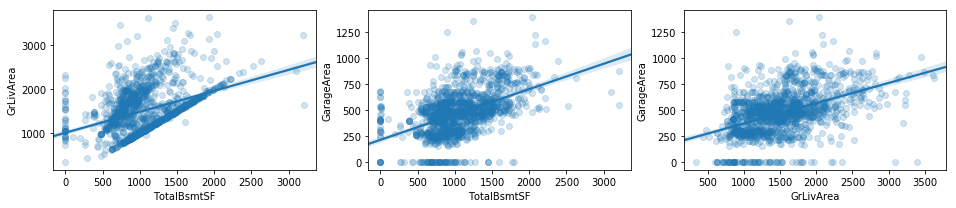

In [25]:
# Bivariate plot between all the areas
plt.figure(figsize=(16,10))
plt.subplot(3,3,1)
sb.regplot(data=train,x='TotalBsmtSF',y='GrLivArea',x_jitter=0.3,scatter_kws={'alpha':1/5});
plt.subplot(3,3,2)
sb.regplot(data=train,x='TotalBsmtSF',y='GarageArea',x_jitter=0.3,scatter_kws={'alpha':1/5});
plt.subplot(3,3,3)
sb.regplot(data=train,x='GrLivArea',y='GarageArea',x_jitter=0.3,scatter_kws={'alpha':1/5});

>**Observation**
![](http://)All three have a positive correlation with each other.

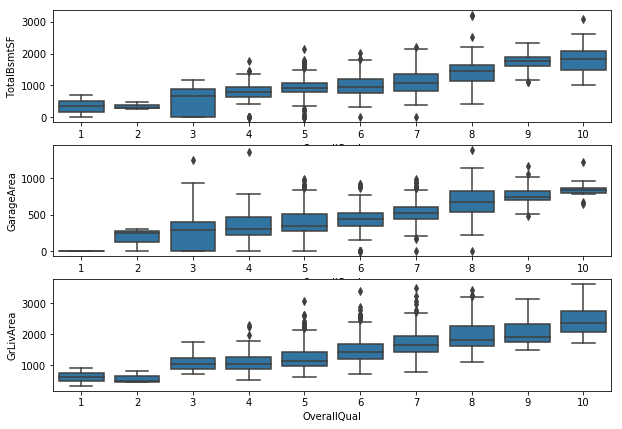

In [26]:
# Bivariate plot of Quality vs. Area
plt.figure(figsize=(10,7))
plt.subplot(3,1,1)
sb.boxplot(data=train,y='TotalBsmtSF',x='OverallQual',color=base_color);
plt.subplot(3,1,2)
sb.boxplot(data=train,y='GarageArea',x='OverallQual',color=base_color);
plt.subplot(3,1,3)
sb.boxplot(data=train,y='GrLivArea',x='OverallQual',color=base_color);

>**Observation**
It is obvious from the above plots that as area increases the quality of the house also increases.

### Multivariate Analysis

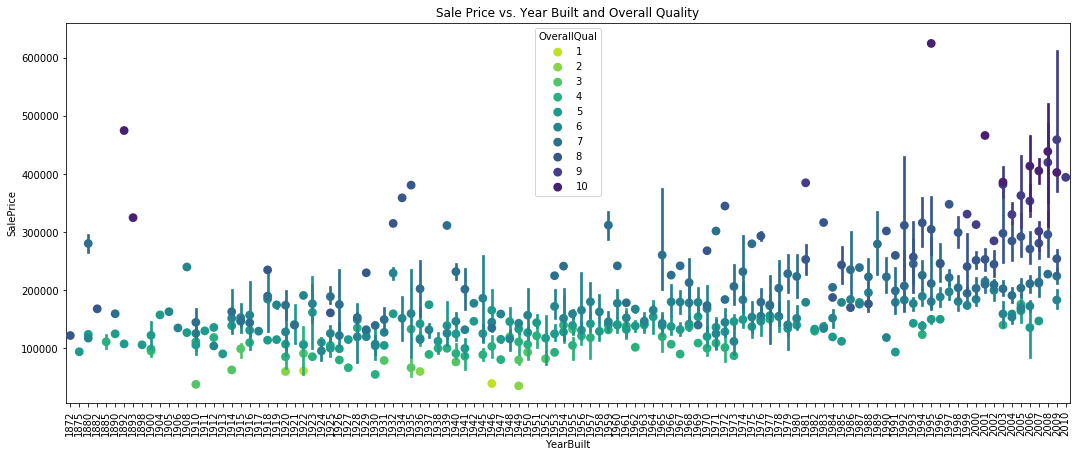

In [27]:
# Multivariate plot of SalePrice vs. YearBuilt and OverallQual
plt.figure(figsize=(18,7))
sb.pointplot(data=train,x='YearBuilt',y='SalePrice',hue='OverallQual',palette='viridis_r',linestyles="");
plt.xticks(rotation=90);
plt.title('Sale Price vs. Year Built and Overall Quality');


>**Observation**
It is clear from the above plot that quality of houses have increased over the years and hance the increase in prices of the house. The sudden price increase that we saw in the plot of SalePrice vs. YearBuilt is because the quality of those houses is the highest.

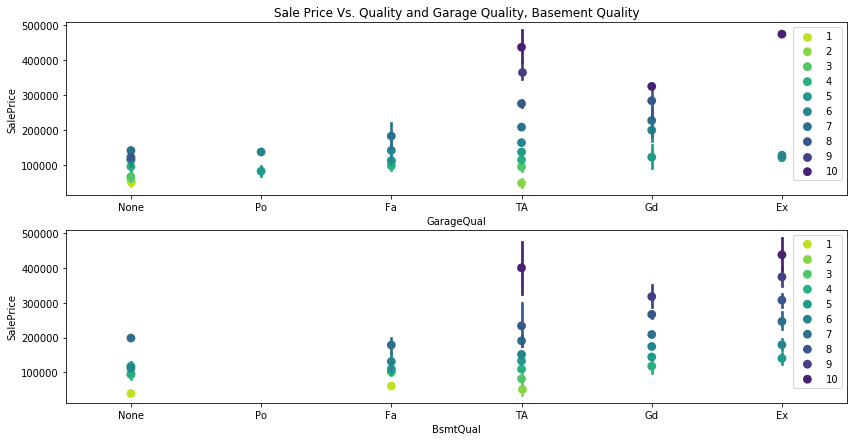

In [28]:
# Multivariate plot of SalePrice Vs. Quality and GarageQual, BsmtQual
plt.figure(figsize=(14,7))
plt.subplot(2,1,1)
plt.title('Sale Price Vs. Quality and Garage Quality, Basement Quality');
sb.pointplot(data=train,hue='OverallQual',y='SalePrice',x='GarageQual',palette='viridis_r',linestyles="",
            order=['None','Po','Fa','TA','Gd','Ex']);
plt.legend(loc=1);
plt.subplot(2,1,2)
sb.pointplot(data=train,hue='OverallQual',y='SalePrice',x='BsmtQual',palette='viridis_r',linestyles="",
            order=['None','Po','Fa','TA','Gd','Ex']);
plt.legend(loc=1);


>**Observation**
High quality in garage and basement quality leads to high overall quality and thus high sale price.

In [29]:
def mean_poly(x, y, bins = 10, **kwargs):
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linspace(x.min(), x.max(), bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # compute counts
    data_bins = pd.cut(x, bins, right = False,
                       include_lowest = True)
    means = y.groupby(data_bins).mean()

    # create plot
    plt.errorbar(x = bin_centers, y = means, **kwargs)

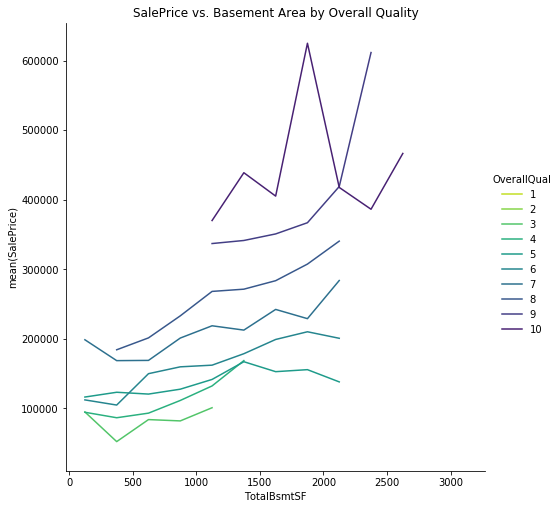

In [30]:
# Lineplot of SalePrice and TotalBsmtSF using OverallQual as hue
bin_edges = np.arange(0, train['TotalBsmtSF'].max()+250, 250)
g = sb.FacetGrid(data = train, hue = 'OverallQual',size=7,palette='viridis_r');
g.map(mean_poly, "TotalBsmtSF", "SalePrice", bins = bin_edges);
g.set_ylabels('mean(SalePrice)');
g.add_legend();
plt.title('SalePrice vs. Basement Area by Overall Quality');

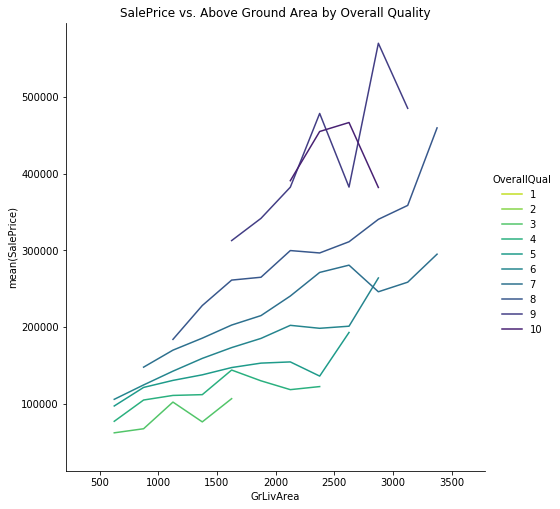

In [31]:
# Lineplot of SalePrice and GrLivArea using OverallQual as hue
bin_edges = np.arange(0, train['GrLivArea'].max()+250, 250)
g = sb.FacetGrid(data = train, hue = 'OverallQual',size=7,palette='viridis_r');
g.map(mean_poly, "GrLivArea", "SalePrice", bins = bin_edges);
g.set_ylabels('mean(SalePrice)');
g.add_legend();
plt.title('SalePrice vs. Above Ground Area by Overall Quality');

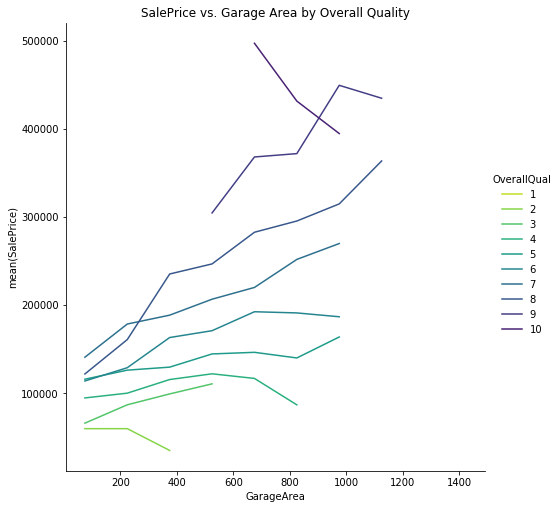

In [32]:
# Lineplot of SalePrice and GarageArea using OverallQual as hue
bin_edges = np.arange(0, train['GarageArea'].max()+150, 150)
g = sb.FacetGrid(data = train, hue = 'OverallQual',size=7,palette='viridis_r');
g.map(mean_poly, "GarageArea", "SalePrice", bins = bin_edges);
g.set_ylabels('mean(SalePrice)');
g.add_legend();
plt.title('SalePrice vs. Garage Area by Overall Quality');

>**Observation**
It is very clear from the above line plots that as the area(above ground, basement and garage) and quality  of the house increases the price of the house also increases. All the three variables have a positive correlation.

## Model and Predict
Previuosly I had used Random Forest for my predcition, while it is a good algorithm the XGBRegressor gives better results.
I have not removed the code for Random Forest.

In [33]:
# Drop object features
'''
for df in combine:
    df.drop(columns=['MSZoning','SaleCondition','SaleType','PavedDrive','GarageCond','GarageQual','GarageFinish',
                    'GarageType','FireplaceQu','Functional','KitchenQual','Heating','HeatingQC','CentralAir',
                     'Electrical','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
                     'BsmtFinType1','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Street',
                     'LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
                     'Condition2','BldgType','HouseStyle','BsmtFinType2' ],inplace=True)
'''

"\nfor df in combine:\n    df.drop(columns=['MSZoning','SaleCondition','SaleType','PavedDrive','GarageCond','GarageQual','GarageFinish',\n                    'GarageType','FireplaceQu','Functional','KitchenQual','Heating','HeatingQC','CentralAir',\n                     'Electrical','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',\n                     'BsmtFinType1','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Street',\n                     'LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',\n                     'Condition2','BldgType','HouseStyle','BsmtFinType2' ],inplace=True)\n"

In [34]:
# Merge the two datasets
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test))

In [35]:
# Get dummy variables
all_data=pd.get_dummies(all_data)

In [36]:
# Seperate the combined dataset into test and train data
test=all_data[all_data['SalePrice'].isnull()]
train=all_data[all_data['Id'].isnull()]

In [37]:
# Check if the new and old sizes are equal
assert train.shape[0]==ntrain
assert test.shape[0]==ntest

In [38]:
# Drop extra columns
test.drop(columns='SalePrice',inplace=True)
train.drop(columns='Id',inplace=True)
test['Id']=test['Id'].astype(int)

In [39]:
X_train=train.drop(columns='SalePrice')
Y_train=train['SalePrice']
X_test=test.drop(columns='Id')

In [40]:
'''
# Apply Random Forest
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest
'''

'\n# Apply Random Forest\nrandom_forest = RandomForestClassifier(n_estimators=1000)\nrandom_forest.fit(X_train, Y_train)\nY_pred = random_forest.predict(X_test)\nrandom_forest.score(X_train, Y_train)\nacc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)\nacc_random_forest\n'

In [41]:
# Apply XGBRegressor
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,Y_train)
Y_pred = xgb.predict(X_test)

In [42]:
final_df = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": Y_pred
    })


In [43]:
# Save the dataframe to a csv file
final_df.to_csv('submission.csv',index=False)

If my approach was helpful to you please upvote this notebook. I will apply new algorithms as and when I learn them. :)